<hr>
<font size=5 color='#3E54D3'> <b> Artwork Generation </b> </font> 
<hr/>

In this project we will try to generate new art portraits using Deeply Convolutional Generative Adversarial Network. We will be using the [Art Portraits Dataset](https://www.kaggle.com/datasets/karnikakapoor/art-portraits) from Kaggle that contains 4117 images.

## 1 - Loading packages

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torch
import torch.nn as nn
import torch.optim as optim
import zipfile
from torchvision import transforms, datasets
from torch.utils.data import Subset, random_split, DataLoader, Dataset
from PIL import Image
import gc

In [2]:
gc.collect()
torch.cuda.empty_cache()

In [3]:
USE_GPU = True
dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
    dtype = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor

# Constant to control how frequently we print train loss.
print_every = 100
print('using device:', device)
print('dtype:', dtype)

using device: cuda
dtype: <class 'torch.cuda.FloatTensor'>


## 2 - Data preparation

In [4]:
images_path = 'Portraits/'
images_list = os.listdir(images_path)

In [5]:
len(images_list)

4117

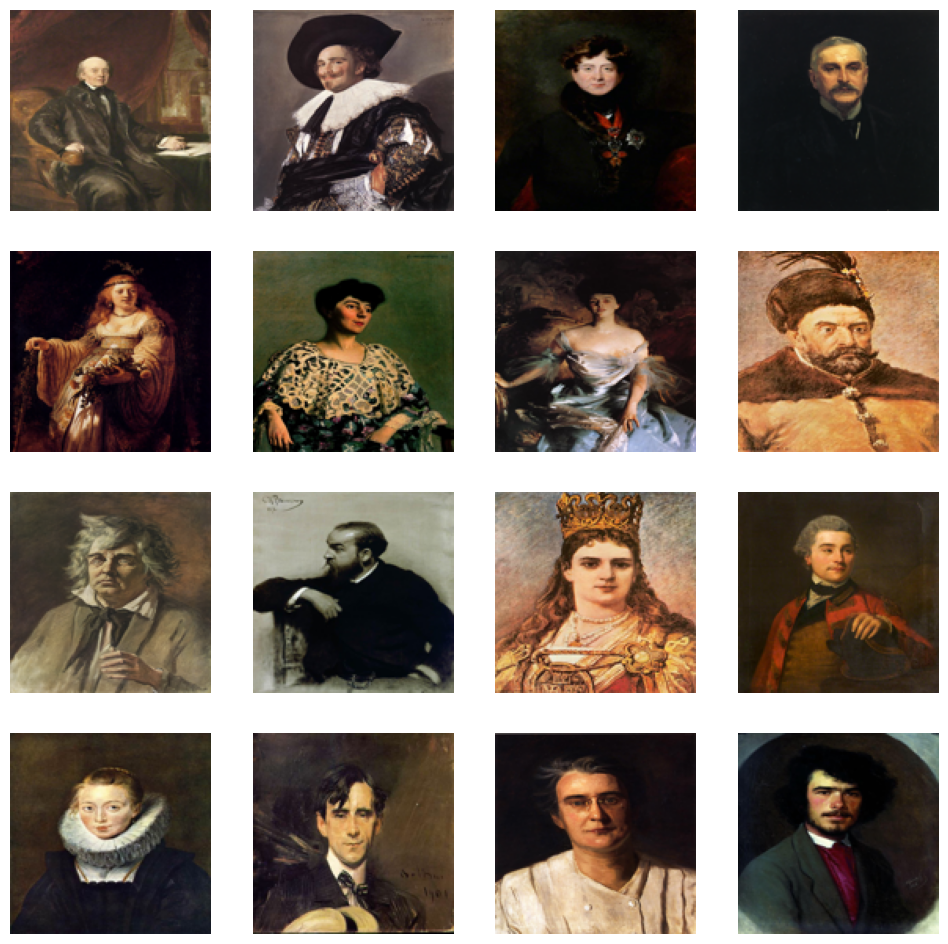

In [6]:
fig = plt.figure(figsize=(12, 12))

for i in range(16):
    plt.subplot(4, 4, i+1)
    img = Image.open(os.path.join(images_path, images_list[i]))
    img = img.resize((128, 128))
    plt.imshow(img)
    plt.axis('off')


In [7]:
class ArtworkDataset(Dataset):
    def __init__(self, folder, transform):
        super().__init__()
        self.images_list = os.listdir(images_path)
        self.folder = folder
        self.transform = transform

    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, ix):
        image_path = os.path.join(self.folder, self.images_list[ix])
        image = Image.open(image_path)
        if len(image.getbands()) != 3:
            image = image.convert('RGB')
        image = self.transform(image)
        return image

In [8]:
BATCH_SIZE = 128
NOISE_DIM = 100
IMG_SIZE = 64

In [9]:
transform = transforms.Compose([transforms.Resize(IMG_SIZE),
                                transforms.CenterCrop(IMG_SIZE),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_ds = ArtworkDataset(images_path, transform=transform)

In [10]:
len(train_ds)

4117

In [11]:
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)

In [12]:
def plot_data(generator):
    imgs = next(generator)
    # re-normalize the images for plotting
    # mean = np.array([0.485, 0.456, 0.406])
    # std = np.array([0.229, 0.224, 0.225])
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    imgs = imgs * std[None, :, None, None] + mean[None, :, None, None]

    fig = plt.figure(figsize=(8, 8))

    for i in range(25):
        plt.subplot(5, 5, i+1)
        image = imgs[i].numpy()
        image = np.transpose(image, (1, 2, 0))
        plt.imshow((image * 255).astype(np.uint8))
        plt.imshow(image)
        plt.axis('off')

    fig.tight_layout()

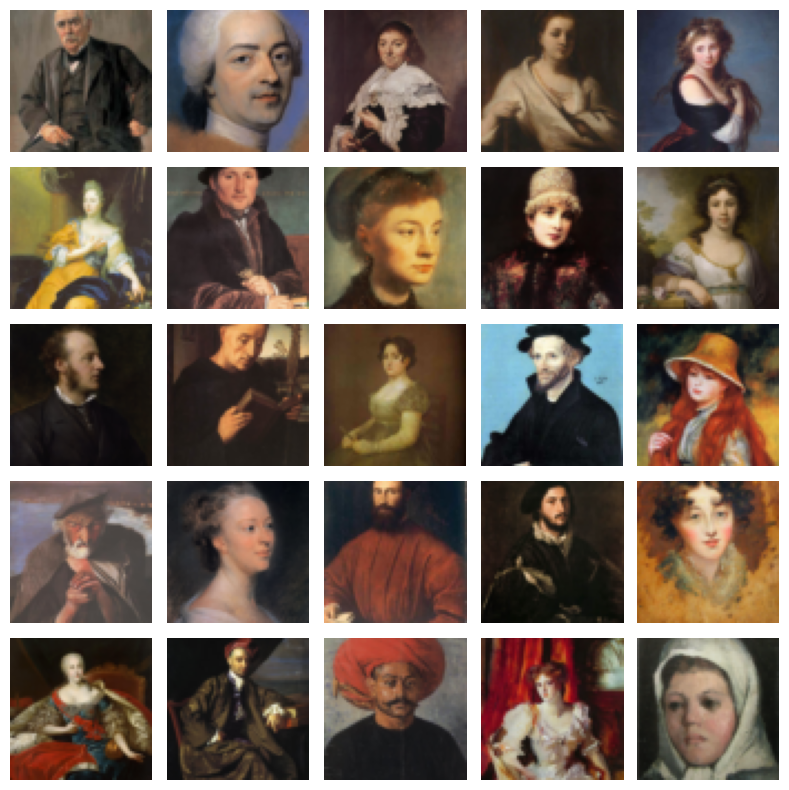

In [13]:
plot_data(iter(train_dl))

## 3 - Generative Adversarial Networks

Generative Adversarial Networks were introduced in 2014 by [Goodfellow et al.](https://arxiv.org/abs/1406.2661), as a way to train generative models. In a GAN, we build two different neural networks. Our first network is a traditional classification network, called the **discriminator**. The discriminator takes in images and classifies them as being real (belonging to the training set) or fake (not present in the training set). Our other network, called the **generator**, takes in random noise as input and transforms it using a neural network to produce images. The goal of the generator is to fool the discriminator into thinking the images it produced are real. This framework corresponds to a minimax two-player game with value $V(G, D)$:

We want to learn generator's distribution $p_g$ over data $x$, for that we define a prior distribution on input noise variables $p_z(z)$. The mapping of $z$ to the data space is then $G(z; \theta_g)$, where $\theta_g$ are the generator network's parameters. The discriminator $D(x; \theta_g)$ outputs a single scalar, that represents the probability of $x$ coming from the data, rather than from $p_g$. We train $D$ to maximize the probability of assigning the correct label to both training examples and samples from $G$. At the same time we train $G$ to minimize $\log(1 - D(G(z)))$:

$$
\min_{G}\max_D V(D, G) = \min_{G}\max_D \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right].
$$

In practice optimizing with respect to $\log(1 - D(G(z)))$ may lead to vanishing gradients in the early stages of learning, when the discriminator is confident in its predictions. What we can do instead is to train $G$ to maximize $\log D(G(z))$. So we will follow the steps

1. Update the generator ($G$) to maximize the probability of the discriminator making the incorrect choice on generated data:

$$
\max_G \mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]
$$

2. Update the discriminator ($D$), to maximize the probability of the discriminator making the correct choice on real and generated data:

$$
\max_D \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]
$$

### 3.1 - Model details

To build the discriminator and the generator networks we will use Convolutional Neural Networks ([DCGAN](https://arxiv.org/abs/1511.06434)).

**Discriminator**: The discriminator receives images of size $3 \times 64 \times 64$, which are passed through four convolutional blocks, consisting of a convolutional layer, followed by BatchNorm and leaky ReLU. After each convolutional block the number of channels is doubled while the spatial dimensionality is halved. The output from the last convolutional block is flattened and passed through a fully-connected block to obtain final scalar prediction.

**Generator**: The generator takes a vector, $z$, of size 100 as input. Then, this vector is passed through a series of transposed convolutions using `nn.ConvTranspose2d()`, which upsamples the feature maps until the spatial dimension reaches $64 \times 64$. The number of channels is halved after each transposed convolutional layer, except the last one, which uses 3 filters to generate a color image. Each transposed convolutional layer is followed by BatchNorm and leaky ReLU activation functions, except the last one, which uses tanh activation (without BatchNorm).  


<font color='#021f69'> <b>Additional notes: </b></font>
    
* BatchNorm helps speed up learning, as it smooths out the optimization landscape ([How Does Batch Normalization Help Optimization?](https://arxiv.org/abs/1805.11604)).
* We use leaky ReLU instead of standard ReLU to avoid dying ReLU problem.
* Since BatchNorm already has a shift parameter, $\beta$, we do not use bias units.
* Instead of applying sigmoid activation directly in the network, we compute the loss from logits to increase computational stability.


In [14]:
def dc_discriminator():
    """
    Build and return a PyTorch model for the DCGAN discriminator.
    """
    model = nn.Sequential(
        # input size = 3 x 64 x 64
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False), # -> 64 x 32 x 32
        nn.LeakyReLU(0.2),

        nn.Conv2d(64, 128, 4, 2, 1, bias=False), # -> 128 x 16 x 16
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(128, 256, 4, 2, 1, bias=False), # -> 256 x 8 x 8
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(256, 512, 4, 2, 1, bias=False), # -> 512 x 4 x 4
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(512, 1, 4, 1, 0, bias=False), # -> 1 x 1 x 1

        nn.Flatten()
#         nn.Linear(4*4*512, 4*4*512),
#         nn.LeakyReLU(0.01),
#         nn.Linear(4*4*512, 1)
    )

    return model

In [15]:
def dc_generator(input_size):
    """
    Build and return a PyTorch model for the DCGAN generator.
    """
    model = nn.Sequential(
        nn.ConvTranspose2d(input_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2, inplace=True),

        nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False), # -> 256 x 8 x 8
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2, inplace=True),

        nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False), # -> 128 x 16 x 16
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2, inplace=True),

        nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False), # -> 64 x 32 x 32
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2, inplace=True),

        nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False), # 3 x 64 x 64
        nn.Tanh() # outputs between -1 and 1
    )

    return model

In [16]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [17]:
def create_noise(batch_size, z_size, mode_z='uniform'):
    if mode_z == 'uniform':
        input_z = torch.rand(batch_size, z_size, 1, 1)*2 - 1 # uniform from -1 to 1
    elif mode_z == 'normal':
        input_z = torch.randn(batch_size, z_size, 1, 1)
    return input_z

### 3.2 - Loss functions

The generator loss is:

$$
\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right],
$$

and the discriminator loss is:

$$
\ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right].
$$

In [18]:
def bce_loss(input, target):
    bce = nn.BCEWithLogitsLoss()
    
    return bce(input, target)

def discriminator_loss(logits_real, logits_fake):
    """
    Computes the discriminator loss.

    Inputs:
    - logits_real: PyTorch Tensor of shape (N,) giving scores for the real data.
    - logits_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.

    Returns:
    - loss: PyTorch Tensor containing (scalar) the loss for the discriminator.
    """

    real_loss = bce_loss(logits_real, torch.ones_like(logits_real).type(dtype))
    fake_loss = bce_loss(logits_fake, torch.zeros_like(logits_fake).type(dtype))
    loss = real_loss + fake_loss

    return loss

def generator_loss(logits_fake):
    """
    Computes the generator loss.

    Inputs:
    - logits_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.

    Returns:
    - loss: PyTorch Tensor containing the (scalar) loss for the generator.
    """

    loss = bce_loss(logits_fake, torch.ones_like(logits_fake).type(dtype))

    return loss

In [19]:
def run_a_gan(D, G, D_solver, G_solver, loader_train, show_every=10,
              batch_size=128, noise_size=100, num_epochs=10, save_images=50):
    """
    Train a GAN

    Inputs:
    - D, G: PyTorch models for the discriminator and generator
    - D_solver, G_solver: torch.optim Optimizers to use for training the
      discriminator and generator.
    - show_every: Show losses after every show_every iterations.
    - batch_size: Batch size to use for training.
    - noise_size: Dimension of the noise to use as input to the generator.
    - num_epochs: Number of epochs over the training dataset to use for training.
    - save_images: Save images for later visualization after save_images iterations
    
    Returns:
    - images: List of images saved after every save_images iterations
    - disc_loss: History log of the discriminator loss.
    - gen_loss: History log of the generator loss.
    - final_images: Numpy array of images generated after the last iteration.
    """
    images = []
    gen_loss = []
    disc_loss = []
    total_iter_number = (4117 // batch_size) * num_epochs
    final_images = np.zeros((16, 3, 128, 128))
    
    iter_count = 0
    for epoch in range(num_epochs):
        for i, x in enumerate(loader_train):
            # train discriminator on real images
            D_solver.zero_grad() # flush the gradients from previous batch
            real_data = x.type(dtype) # move to device
            batch_size = x.size(0)
            logits_real = D(real_data).type(dtype)

            # train discriminator on fake images
            input_z = create_noise(batch_size, noise_size).type(dtype)
            fake_images = G(input_z).detach()
            logits_fake = D(fake_images)

            # compute total loss
            d_total_error = discriminator_loss(logits_real, logits_fake)
            d_total_error.backward()
            D_solver.step()

            # train generator
            G_solver.zero_grad()
            input_z = create_noise(batch_size, noise_size).type(dtype)
            fake_images = G(input_z)

            g_logits_fake = D(fake_images)
            g_error = generator_loss(g_logits_fake)
            g_error.backward()
            G_solver.step()
            
            gen_loss.append(g_error.item())
            disc_loss.append(d_total_error.item())

            # intermediate results for printing
            if iter_count % show_every == 0:
                print('Iter: {}, D_loss: {:.4}, G_loss:{:.4}'.format(iter_count, d_total_error.item(), g_error.item()))
            if iter_count % save_images == 0:
                imgs_numpy = fake_images.data.cpu().numpy()
                images.append(imgs_numpy[0:16])

            iter_count += 1
            # save final images
            if iter_count == total_iter_number:
                final_images = fake_images.data.cpu().numpy()[0:16]

    return images, disc_loss, gen_loss, final_images

In [20]:
disc_model = dc_discriminator().type(dtype)
disc_model.apply(weights_init)
gen_model = dc_generator(NOISE_DIM).type(dtype)
gen_model.apply(weights_init)

disc_solver = optim.Adam(disc_model.parameters(), lr=0.0002, betas=(0.5, 0.999))
gen_solver = optim.Adam(gen_model.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [21]:
images, disc_loss, gen_loss, final_images = run_a_gan(
    disc_model,
    gen_model,
    disc_solver,
    gen_solver,
    train_dl,
    num_epochs=300,
    show_every=1000, 
    save_images=1000
)

Iter: 0, D_loss: 1.733, G_loss:3.929
Iter: 1000, D_loss: 0.4887, G_loss:2.297
Iter: 2000, D_loss: 0.4526, G_loss:2.697
Iter: 3000, D_loss: 0.4467, G_loss:3.01
Iter: 4000, D_loss: 0.3472, G_loss:3.349
Iter: 5000, D_loss: 0.21, G_loss:2.882
Iter: 6000, D_loss: 0.1614, G_loss:4.48
Iter: 7000, D_loss: 0.08876, G_loss:3.774
Iter: 8000, D_loss: 0.05311, G_loss:4.065
Iter: 9000, D_loss: 0.1186, G_loss:4.106


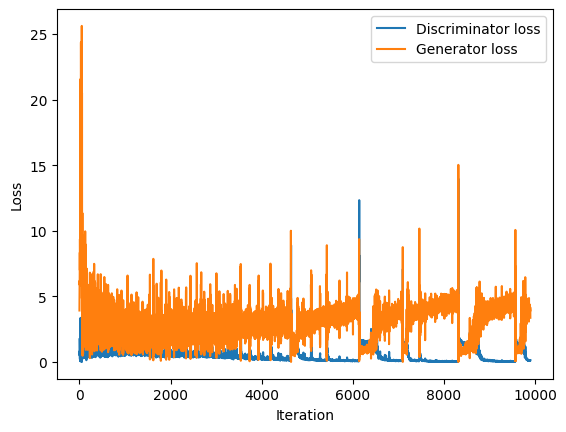

In [22]:
plt.plot(disc_loss, label='Discriminator loss')
plt.plot(gen_loss, label='Generator loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [23]:
def show_images(images):
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    images = images * std[None, :, None, None] + mean[None, :, None, None]
    fig = plt.figure(figsize=(8, 8))

    for i in range(16):
        plt.subplot(4, 4, i+1)
        image = images[i]
        image = np.transpose(image, (1, 2, 0))
        plt.imshow((image * 255).astype(np.uint8))
        plt.axis('off')

Iter: 0


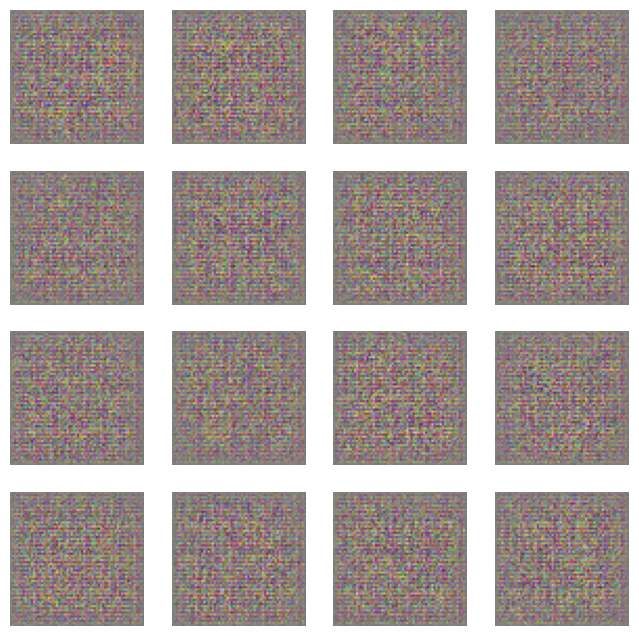


Iter: 1000


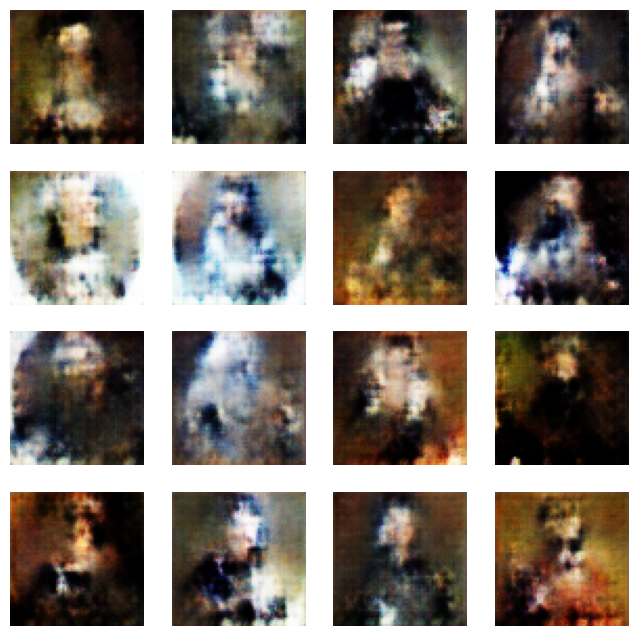


Iter: 2000


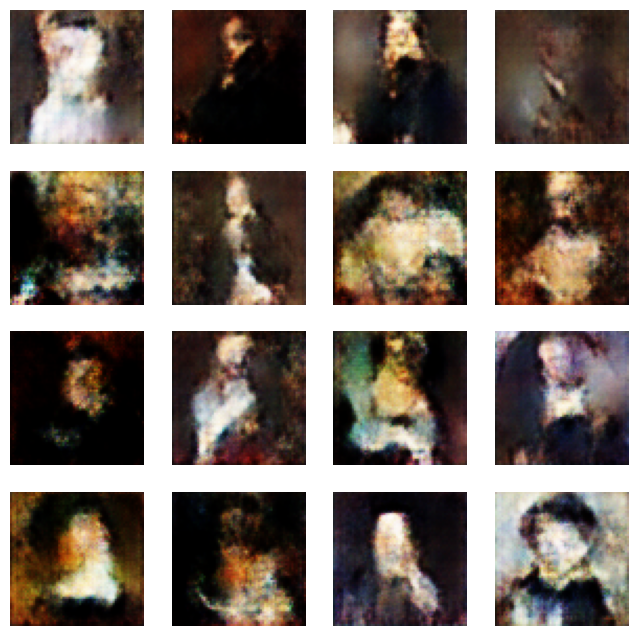


Iter: 3000


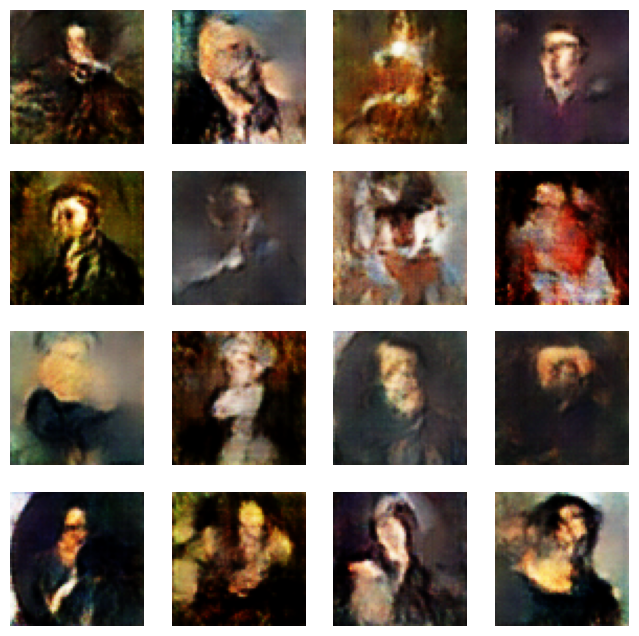


Iter: 4000


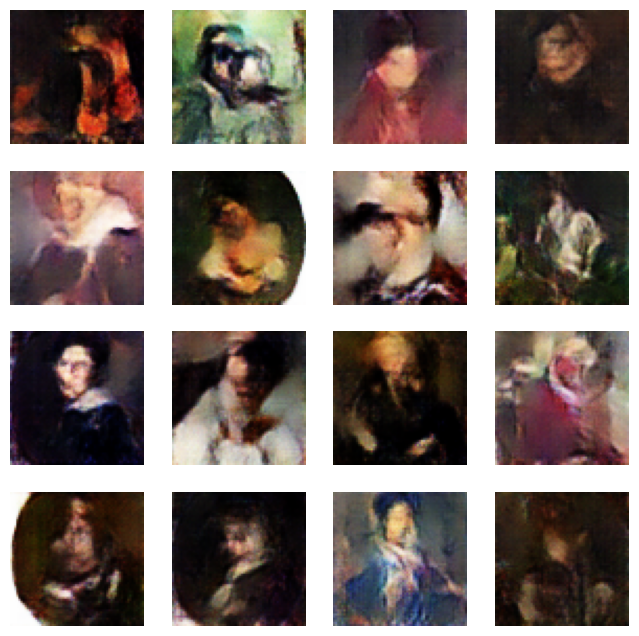


Iter: 5000


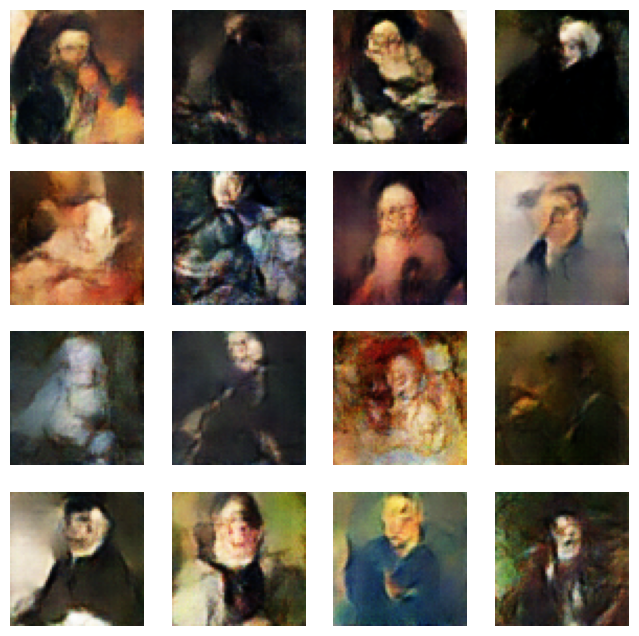


Iter: 6000


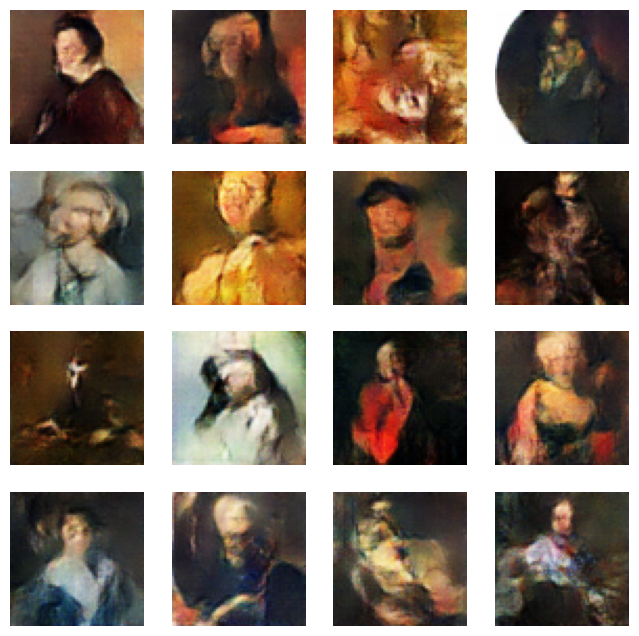


Iter: 7000


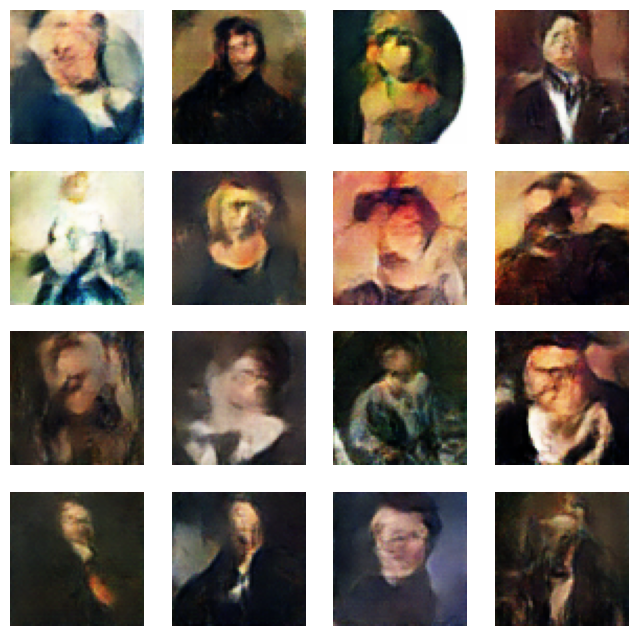


Iter: 8000


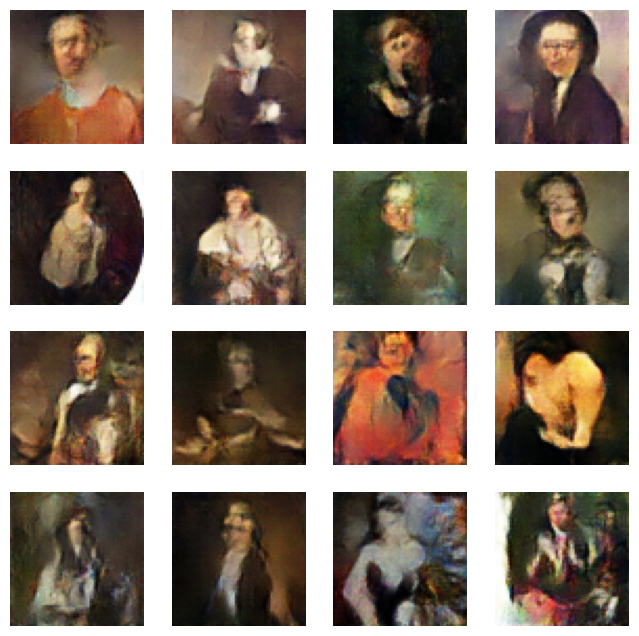


Iter: 9000


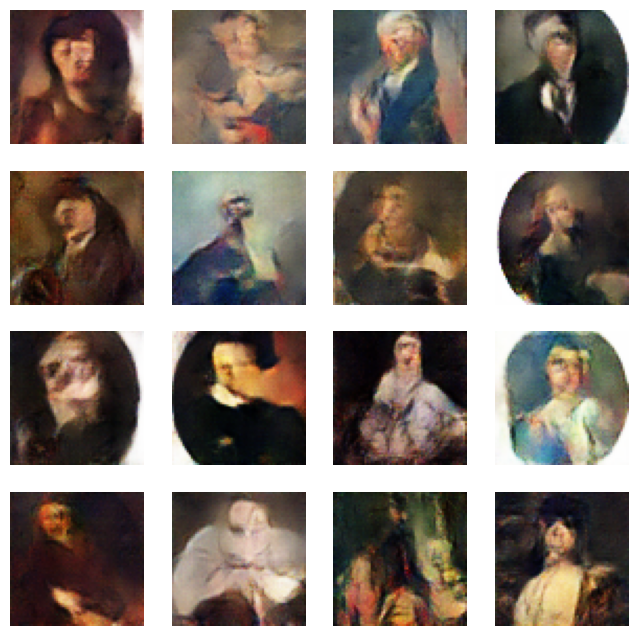

In [24]:
numIter = 0
for img in images:
    print("Iter: {}".format(numIter))
    show_images(img)
    plt.show()
    numIter += 1000
    print()

In [25]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.5, 0.5, 0.5])
final_images2 = final_images * std[None, :, None, None] + mean[None, :, None, None]

for i in range(16):
    im = final_images2[i]
    im = im.transpose(1, 2, 0) * 255
    im = Image.fromarray(im.astype(np.uint8), 'RGB')
    im.save(f"final_images/final_image{i}.png")

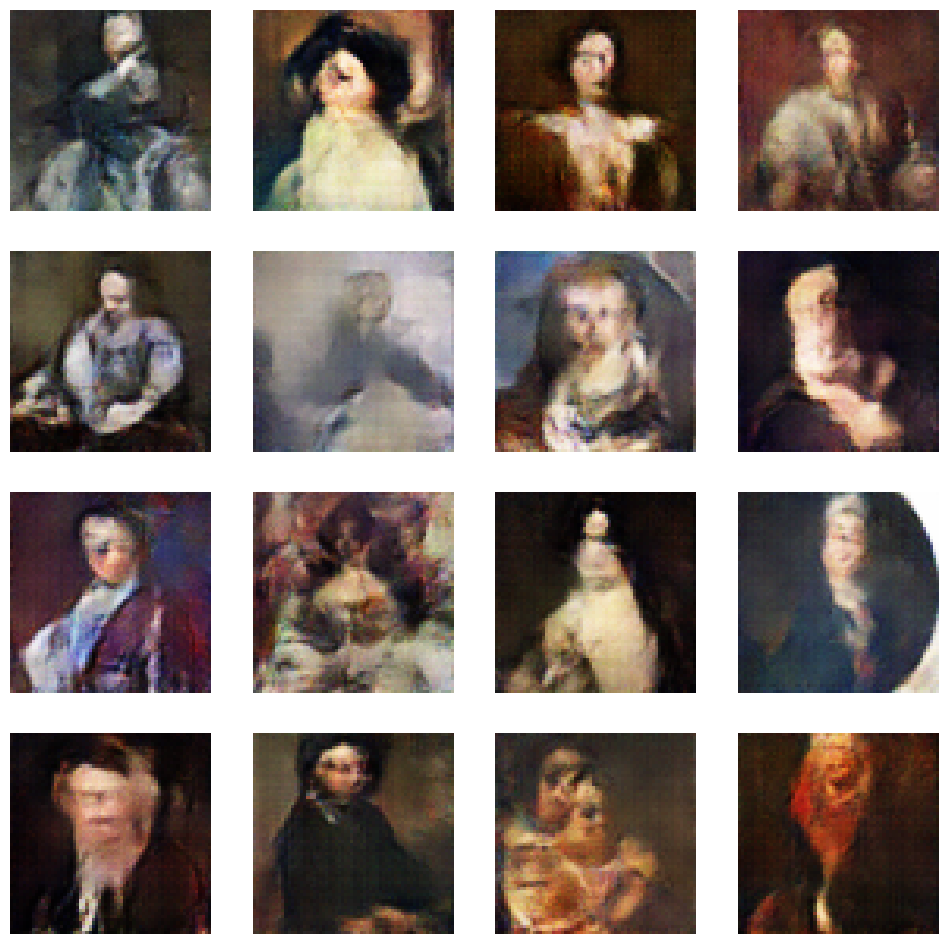

In [26]:
fig = plt.figure(figsize=(12, 12))

for i in range(16):
    plt.subplot(4, 4, i+1)
    image = final_images2[i]
    image = np.transpose(image, (1, 2, 0))
    plt.imshow(image)
    plt.axis('off')